# Final Project

## Data

The two data sets we will be using are called `tracks` and `usertracks`. `tracks` is a large dataset from kaggle that contains a representative sample of spotify songs released between 1900 and 2021. `usertracks` is a user's data set (Evan's) that was collected from spotify using the api. Because using the api requires authorization, a downloaded version of the data set is included. You can use `usertracks = pd.read_csv('usertracks.csv')`, for example, instead of the api requests, and the rest of the code will work the same. Data can be found at https://github.com/evancoons22/Stats21FinalProject


Here is the link to the kaggle data:

https://www.kaggle.com/datasets/lehaknarnauli/spotify-datasets?select=tracks.csv

### Importing personal data with spotify api and requests library + reading in larger dataset from google drive

In [1]:
import requests
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import datetime

This is to import the large data set in google colab. If opening the notebook with jupyter notebook or lab, use something like `pd.read_csv('tracks.csv')`, like normal. 

In [2]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive


Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive


In [3]:
tracks = pd.read_csv('/gdrive/MyDrive/tracks.csv', parse_dates = ["release_date"])

In [4]:
username = 'coonsevan'

In [5]:
## This Access token needs to be reset often, as it expires after a set amount of time.
## Go to the link below and click 'Get Token' and copy and paste into ACCESS_TOKEN
## https://developer.spotify.com/console/get-current-user-saved-tracks/?market=ES&limit=150&offset=5
## Run this first request to make sure it works before running requests to get all of the data. 
ACCESS_TOKEN = 'BQDf2AKfaKV8W9D_AtVU9HvVgScuUcFmVobSm1rPRjItIJaCsYrVWv2biTn1pAQ2pXdP4W3Ob5tUuadhei9UAO9BoTqIY2r5wmKtqzerwoiKn8S0ARVclxILGAPxbP7d2fpi_AFIFPMF_jW_RT9J5nSF-x7B9l_cBvictTQC1P7LbeAawir7irezADxSzDD8AWvAbHLxBU9LXfEIFd_-xGNSrWtOTLJQ8jpa3pEDdBYnnn5JOQClc6ph-1XJpi-F4qUy'
SPOTIFY_URL_TRACKS = f'https://api.spotify.com/v1/users/{username}/tracks'
response2 = requests.get(
                        SPOTIFY_URL_TRACKS,
                        headers = {
                        "Authorization":f"Bearer {ACCESS_TOKEN}",
                        })

response2 = response2.json()
total_songs = response2['total']
total_songs

2234

#### Looping through requests because spotify sets a limit at 50 songs / request

In [6]:
# This code also does a lot of the cleaning of this dataset. 
usertracks = pd.DataFrame()
i = 0

while i < total_songs:
    ENDPOINT_TRACKS = f'https://api.spotify.com/v1/users/{username}/tracks?limit=50&offset={i}'
    
    response = (requests.get(
                        ENDPOINT_TRACKS,
                        headers = {
                        "Authorization":f"Bearer {ACCESS_TOKEN}",
                        })).json()
    limit = len(response['items'])
    new = pd.DataFrame({"id": [(response['items'])[i]['track']['id'] for i in range(limit)], 
                      "name": [(response['items'])[i]['track']['name'] for i in range(limit)],
                      "artists": [(response['items'])[i]['track']['artists'][0]['name'] for i in range(limit)],
                      "popularity": [(response['items'])[i]['track']['popularity'] for i in range(limit)],
                      "duration": [(response['items'])[i]['track']['duration_ms'] for i in range(limit)],
                      "type": [(response['items'])[i]['track']['type'] for i in range(limit)],
                      "explicit": [(response['items'])[i]['track']['explicit'] for i in range(limit)],
                      "date_added": [(response['items'])[i]['added_at'] for i in range(limit)],
                      "release_date": [(response['items'])[i]['track']['album']['release_date'] for i in range(limit)] })
    
    song_ids = list(new['id'])
    s = ','.join([str(n) for n in song_ids])
    ENDPOINT_SONGS = f'https://api.spotify.com/v1/audio-features/?ids={s}'
    song_features = requests.get(ENDPOINT_SONGS, headers = {"Authorization": f"Bearer {ACCESS_TOKEN}", })
    song_features = song_features.json()
    song_features = pd.DataFrame.from_records(song_features['audio_features'])
    new = pd.merge(new, song_features, left_index=True, right_index=True)
    
    usertracks = pd.concat(objs = [usertracks, new])
    i += 50

### Cleaning `usertracks` Data

### `usertracks` is the personal data grabbed from spotify

In [7]:
pd.isnull(usertracks).sum()

id_x                0
name                0
artists             0
popularity          0
duration            0
type_x              0
explicit            0
date_added          0
release_date        0
danceability        0
energy              0
key                 0
loudness            0
mode                0
speechiness         0
acousticness        0
instrumentalness    0
liveness            0
valence             0
tempo               0
type_y              0
id_y                0
uri                 0
track_href          0
analysis_url        0
duration_ms         0
time_signature      0
dtype: int64

In [8]:
usertracks.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2234 entries, 0 to 33
Data columns (total 27 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id_x              2234 non-null   object 
 1   name              2234 non-null   object 
 2   artists           2234 non-null   object 
 3   popularity        2234 non-null   int64  
 4   duration          2234 non-null   int64  
 5   type_x            2234 non-null   object 
 6   explicit          2234 non-null   bool   
 7   date_added        2234 non-null   object 
 8   release_date      2234 non-null   object 
 9   danceability      2234 non-null   float64
 10  energy            2234 non-null   float64
 11  key               2234 non-null   int64  
 12  loudness          2234 non-null   float64
 13  mode              2234 non-null   int64  
 14  speechiness       2234 non-null   float64
 15  acousticness      2234 non-null   float64
 16  instrumentalness  2234 non-null   float64
 1

We will delete duplicate columns and convert the date columns to datetime objects

In [9]:
usertracks.index = range(len(usertracks))

In [10]:
usertracks["date_added"] = pd.to_datetime(usertracks["date_added"])
usertracks["release_date"] = pd.to_datetime(usertracks["release_date"])

In [11]:
usertracks["duration"] = usertracks["duration_ms"].apply(lambda x : x / 1000)

In [12]:
usertracks.drop(["id_y", "type_x", "type_y", "duration_ms", "track_href", "uri", "analysis_url"], axis = 1, inplace = True)

In [13]:
usertracks = usertracks.rename(columns = {"id_x": "id", "type_x": "type"});

In [14]:
(usertracks.columns)

Index(['id', 'name', 'artists', 'popularity', 'duration', 'explicit',
       'date_added', 'release_date', 'danceability', 'energy', 'key',
       'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness',
       'liveness', 'valence', 'tempo', 'time_signature'],
      dtype='object')

In [15]:
(tracks.columns)

Index(['id', 'name', 'popularity', 'duration_ms', 'explicit', 'artists',
       'id_artists', 'release_date', 'danceability', 'energy', 'key',
       'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness',
       'liveness', 'valence', 'tempo', 'time_signature'],
      dtype='object')

In [16]:
usertracks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2234 entries, 0 to 2233
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype              
---  ------            --------------  -----              
 0   id                2234 non-null   object             
 1   name              2234 non-null   object             
 2   artists           2234 non-null   object             
 3   popularity        2234 non-null   int64              
 4   duration          2234 non-null   float64            
 5   explicit          2234 non-null   bool               
 6   date_added        2234 non-null   datetime64[ns, UTC]
 7   release_date      2234 non-null   datetime64[ns]     
 8   danceability      2234 non-null   float64            
 9   energy            2234 non-null   float64            
 10  key               2234 non-null   int64              
 11  loudness          2234 non-null   float64            
 12  mode              2234 non-null   int64              
 13  spe

### Cleaning the `tracks` dataframe

In [17]:
tracks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 586672 entries, 0 to 586671
Data columns (total 20 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   id                586672 non-null  object        
 1   name              586601 non-null  object        
 2   popularity        586672 non-null  int64         
 3   duration_ms       586672 non-null  int64         
 4   explicit          586672 non-null  int64         
 5   artists           586672 non-null  object        
 6   id_artists        586672 non-null  object        
 7   release_date      586672 non-null  datetime64[ns]
 8   danceability      586672 non-null  float64       
 9   energy            586672 non-null  float64       
 10  key               586672 non-null  int64         
 11  loudness          586672 non-null  float64       
 12  mode              586672 non-null  int64         
 13  speechiness       586672 non-null  float64       
 14  acou

In [18]:
pd.isnull(tracks).sum()

id                   0
name                71
popularity           0
duration_ms          0
explicit             0
artists              0
id_artists           0
release_date         0
danceability         0
energy               0
key                  0
loudness             0
mode                 0
speechiness          0
acousticness         0
instrumentalness     0
liveness             0
valence              0
tempo                0
time_signature       0
dtype: int64

String manipulation to replace the weird formatting of the artists names

In [19]:
tracks["artists"][20]

"['Jeanne Saint Bonnet']"

In [20]:
tracks['artists'] = tracks["artists"].apply(lambda x : x.replace("['", ''))
tracks['artists'] = tracks["artists"].apply(lambda x : x.replace("']", ''))

In [21]:
tracks["artists"][20]

'Jeanne Saint Bonnet'

Changing the duration from milliseconds to seconds

In [22]:
tracks['duration']=tracks['duration_ms'].apply(lambda x : x/1000)
tracks.drop("duration_ms", axis = 1, inplace = True)

`release_date` is already datetime64 object

### Finally, making the columns of `usertracks` and `tracks` the same

Dropping the artists id, not really needed. 

In [23]:
tracks.drop(["id_artists"], axis = 1, inplace = True)

In [24]:
tracks.columns

Index(['id', 'name', 'popularity', 'explicit', 'artists', 'release_date',
       'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
       'time_signature', 'duration'],
      dtype='object')

In [25]:
usertracks.columns

Index(['id', 'name', 'artists', 'popularity', 'duration', 'explicit',
       'date_added', 'release_date', 'danceability', 'energy', 'key',
       'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness',
       'liveness', 'valence', 'tempo', 'time_signature'],
      dtype='object')

In [26]:
column_names = (list(tracks.columns)) + ["date_added"]

In [27]:
usertracks = usertracks.reindex(columns = column_names)

In [28]:
usertracks.head()

,id,name,popularity,explicit,artists,release_date,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,duration,date_added
0,4qArKIA7dnmdushoBlkV94,La Escuela No Me Gustó,69,False,Adriel Favela,2018-08-24,0.836,0.766,7,-6.229,0,0.0371,0.323000,0.000001,0.0910,0.844,112.548,4,176.000,2022-06-08 03:42:42+00:00
1,4f7nKn1kTyATS63TYBcIaa,Babygirl Disco,56,False,Six Dior,1951-08-28,0.838,0.615,11,-5.322,0,0.0936,0.321000,0.524000,0.1460,0.318,121.121,4,111.049,2022-06-06 21:42:52+00:00
2,4VsJcIZDzGVeoTwDiEdxF2,The Red Planet,25,False,Scientist,1981-01-01,0.744,0.514,6,-11.634,0,0.0508,0.007590,0.810000,0.0849,0.666,141.367,4,212.933,2022-06-06 17:05:26+00:00
3,4z1YabjDCOGQuv2E4ymKyi,Guided Beam,34,False,Scientist,1981-01-01,0.757,0.451,10,-12.216,1,0.1410,0.000638,0.007310,0.1210,0.732,144.220,4,196.400,2022-06-06 17:04:59+00:00
4,5xeBdH9bBnBdmfmozGCY85,The Sun Comes Up,58,False,Mako Road,2017-08-16,0.699,0.481,9,-10.247,0,0.0353,0.225000,0.004820,0.0938,0.752,146.665,4,254.465,2022-06-05 03:35:00+00:00


In [29]:
tracks.head()

,id,name,popularity,explicit,artists,release_date,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,duration
0,35iwgR4jXetI318WEWsa1Q,Carve,6,0,Uli,1922-02-22,0.645,0.4450,0,-13.338,1,0.4510,0.674,0.7440,0.151,0.127,104.851,3,126.903
1,021ht4sdgPcrDgSk7JTbKY,Capítulo 2.16 - Banquero Anarquista,0,0,Fernando Pessoa,1922-06-01,0.695,0.2630,0,-22.136,1,0.9570,0.797,0.0000,0.148,0.655,102.009,1,98.200
2,07A5yehtSnoedViJAZkNnc,Vivo para Quererte - Remasterizado,0,0,Ignacio Corsini,1922-03-21,0.434,0.1770,1,-21.180,1,0.0512,0.994,0.0218,0.212,0.457,130.418,5,181.640
3,08FmqUhxtyLTn6pAh6bk45,El Prisionero - Remasterizado,0,0,Ignacio Corsini,1922-03-21,0.321,0.0946,7,-27.961,1,0.0504,0.995,0.9180,0.104,0.397,169.980,3,176.907
4,08y9GfoqCWfOGsKdwojr5e,Lady of the Evening,0,0,Dick Haymes,1922-01-01,0.402,0.1580,3,-16.900,0,0.0390,0.989,0.1300,0.311,0.196,103.220,4,163.080


## Questions

Some questions we want to answer with this data are:   
Change over time in metrics like danceability, duration, energy?   
What song attributes have the strongest correlation?  
How a user's data compares and how a user's taste changes over time?  

## Data Visualization

In [30]:
plt.rcParams["figure.figsize"] = (14, 8)

### Finding correlations and relationships

Using pearson method correlation. Credit to Kaggle. 

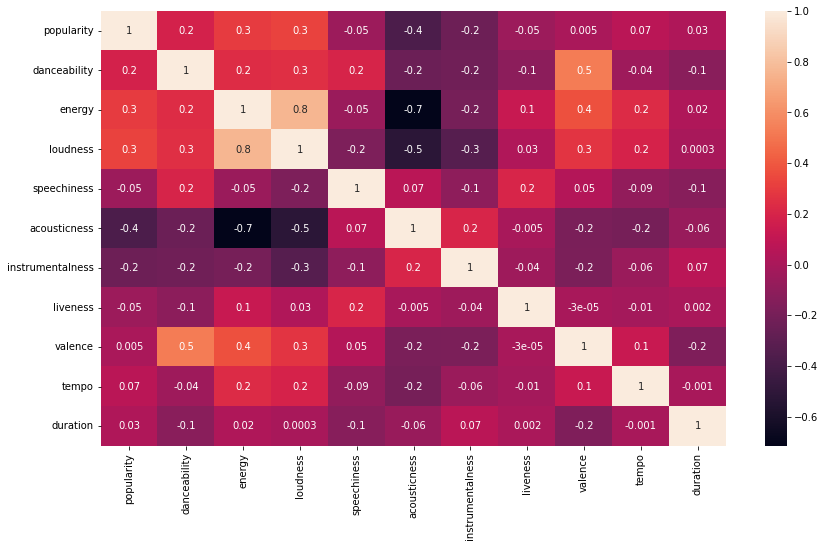

In [31]:
corr_tracks = tracks.drop(["explicit", "key", "mode", "time_signature"], axis = 1).corr(method = "pearson")
plt.figure(figsize=(14,8))
sns.heatmap(corr_tracks, annot=True, fmt='.1g')

Some of the highest correlations are between danceability and valence, energy 
and acousticness, and energy and loudness

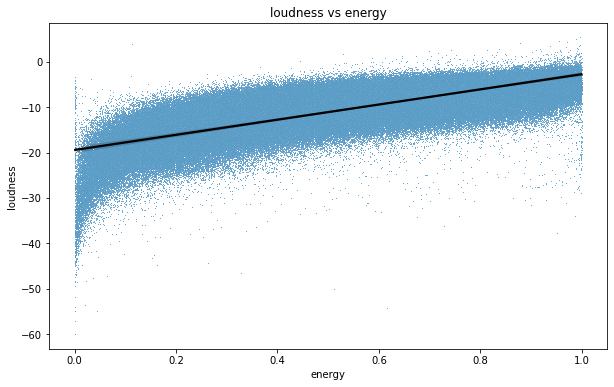

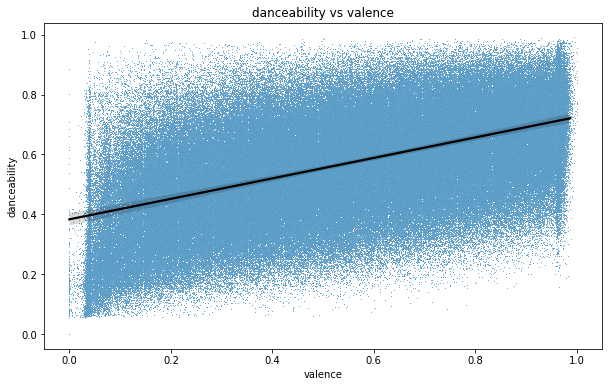

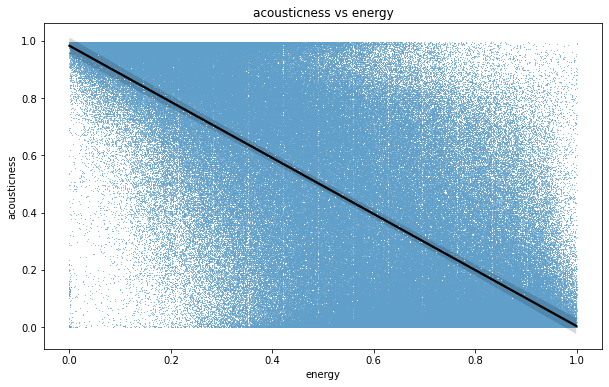

In [32]:
plt.figure(figsize=(10,6))
sns.scatterplot(data = tracks, x = "energy", y = "loudness", s = 1).set(title = "loudness vs energy")
sns.regplot(data = tracks.iloc[list(np.random.randint(0, len(tracks), 1000))], x = "energy", y = "loudness", color = "black", scatter = False);

plt.figure(figsize=(10,6))
sns.scatterplot(data = tracks, x = "valence", y = "danceability", s = 1).set(title = "danceability vs valence")
sns.regplot(data = tracks.iloc[list(np.random.randint(0, len(tracks), 1000))], x = "valence", y = "danceability", color = "black", scatter = False);

plt.figure(figsize = (10, 6))
sns.scatterplot(data = tracks, x = "energy", y = "acousticness", s = 0.8).set(title = "acousticness vs energy")
sns.regplot(data = tracks.iloc[list(np.random.randint(0, len(tracks), 1000))], x = "energy", y = "acousticness", color = "black", scatter = False);

### Trends over time

We can see that the `tracks` dataset has songs collected over the last century. 

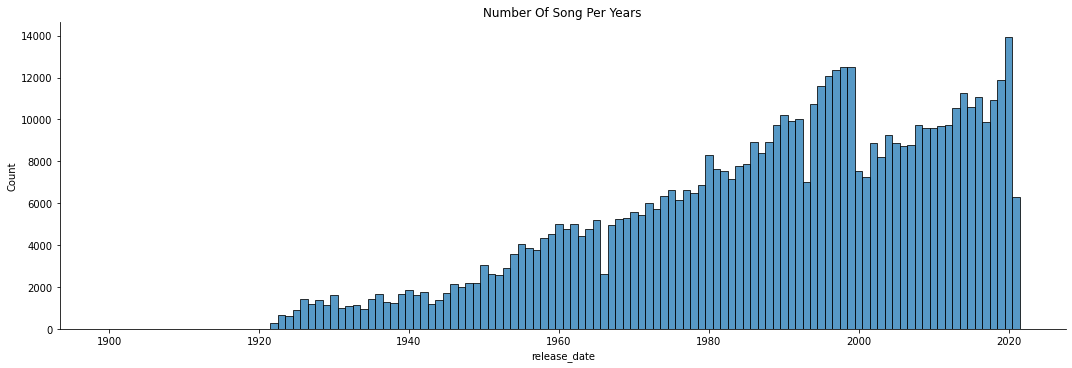

In [33]:
sns.displot(tracks["release_date"].dt.year, discrete=True , aspect=3, height=5 , kind='hist').set(title='Number Of Song Per Years')

This allows us to gain insight into trends over long periods of time, like danceability and duration. 

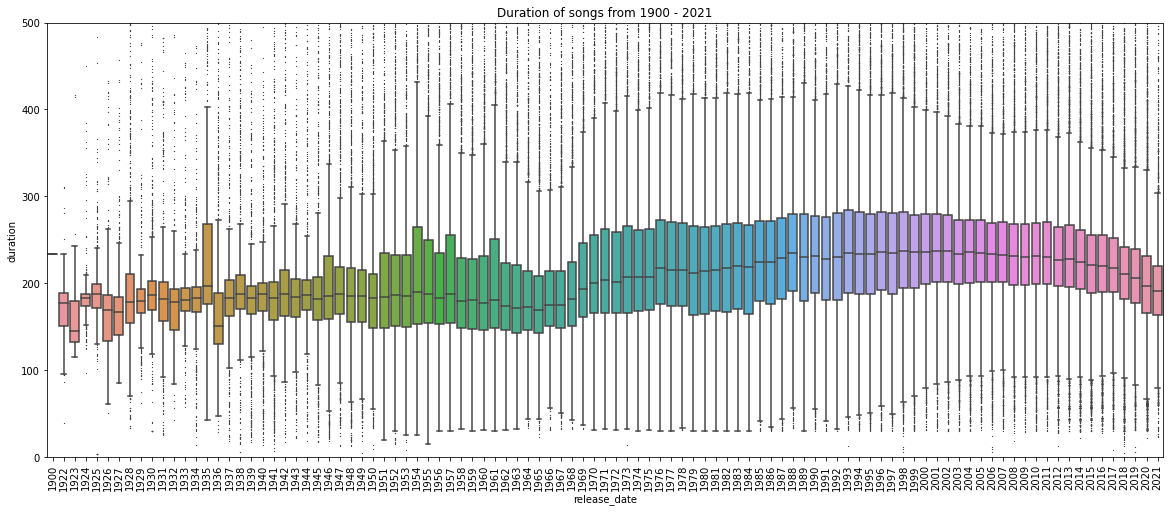

In [34]:
plt.figure(figsize=(20,8))
sns.boxplot(x = tracks.release_date.dt.year, y = tracks.duration, fliersize = 0.4).set(ylim=(0, 500), title = "Duration of songs from 1900 - 2021")
plt.xticks(rotation=90);

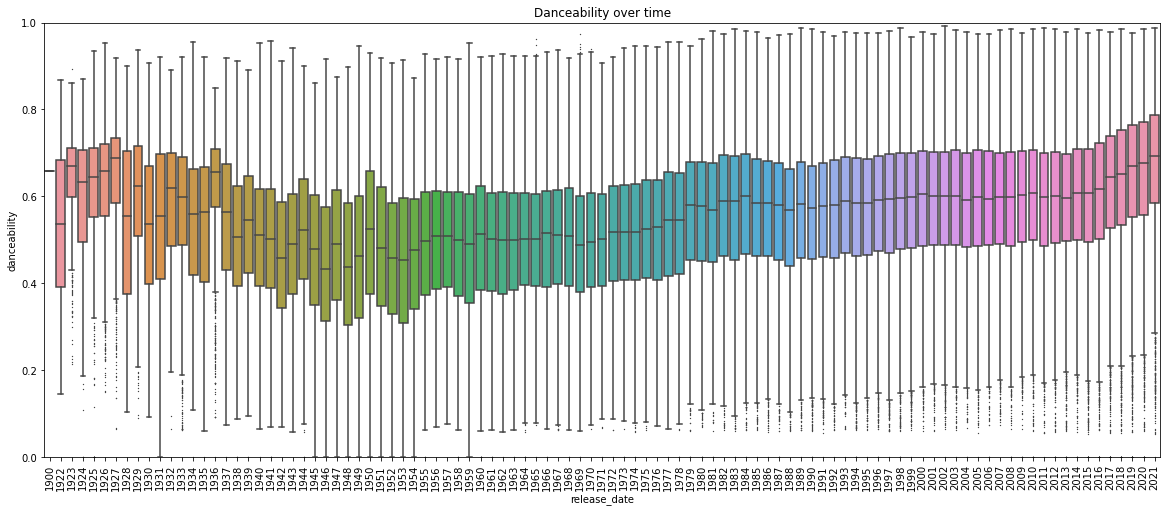

In [35]:
plt.figure(figsize=(20,8))
sns.boxplot(x = tracks.release_date.dt.year, y = tracks.danceability, fliersize = 0.5).set(ylim=(0, 1), title = "Danceability over time")
plt.xticks(rotation=90);

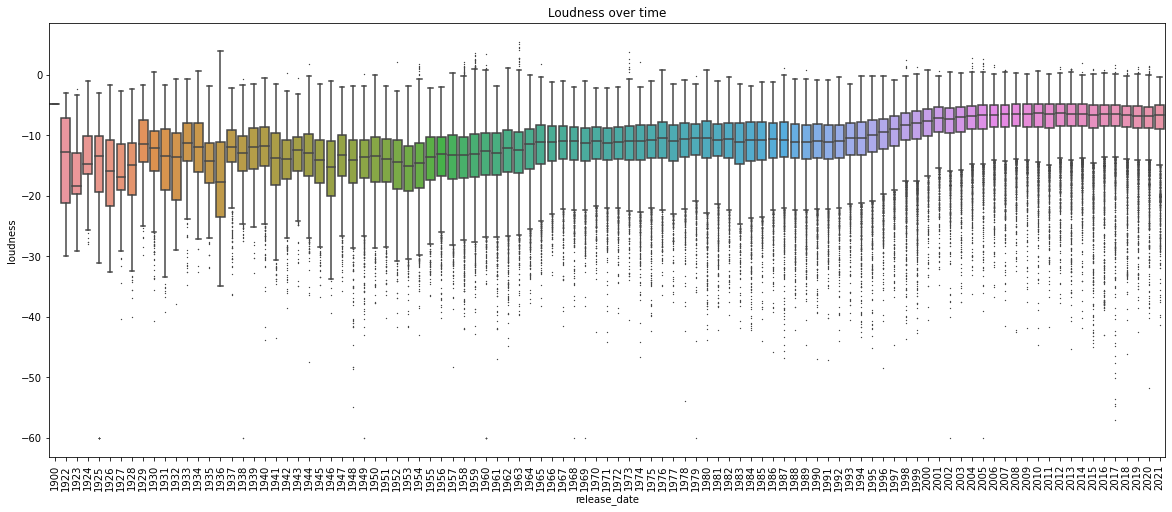

In [36]:
plt.figure(figsize=(20,8))
sns.boxplot(x = tracks.release_date.dt.year, y = tracks.loudness, fliersize = 0.5).set(title = "Loudness over time")
plt.xticks(rotation=90);

Popularity really picks up around 1960. Important to note that popularity is only spotify's metric of popularity, which has been recorded since 2006. 

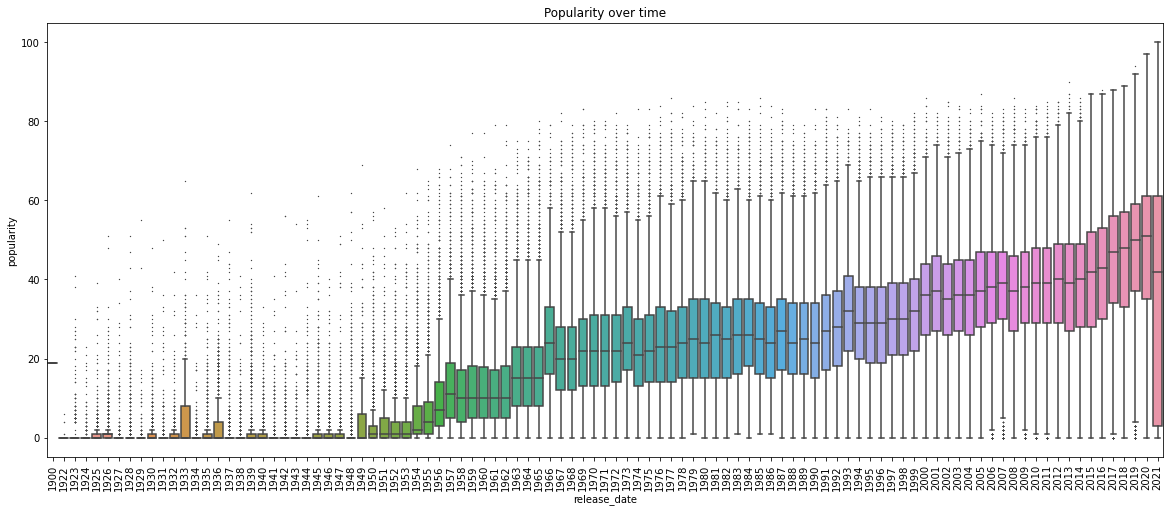

In [37]:
plt.figure(figsize=(20,8))
sns.boxplot(x = tracks.release_date.dt.year, y = tracks.popularity, fliersize = 0.5).set(title = "Popularity over time")
plt.xticks(rotation=90);

## Visualizing user data

After learning about the large `tracks` dataset, we can also gain insights into the user's `usertracks` dataset and compare them.   


Of course, the user's songs are much more modern compared to the larger data set: 

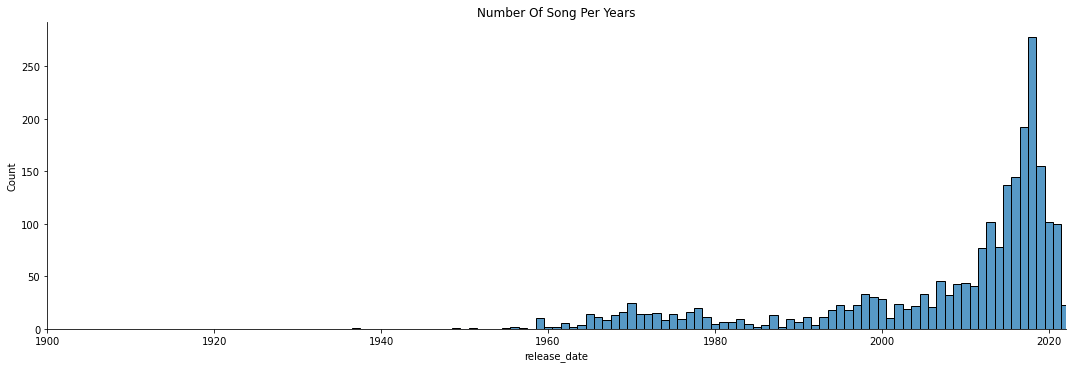

In [38]:
sns.displot(usertracks.release_date.dt.year, discrete=True , aspect=3, height=5 , kind='hist').set(title='Number Of Song Per Years', xlim = (1900, 2022))

Here is the user's preference over time for many characteristics, like danceability, popularity, and energy. This is compared to the average at the time of songs released. 

In [39]:
mean_dance = tracks.pivot_table(index = tracks.release_date.dt.year[tracks.release_date.dt.year > 2014])
mean_user_dance = usertracks.pivot_table(index = usertracks.release_date.dt.year[usertracks.release_date.dt.year > 2014])

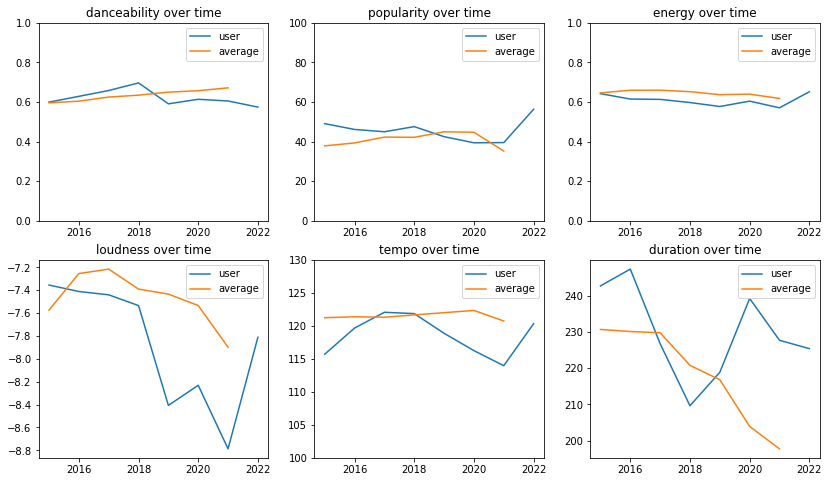

In [40]:
plt.subplot(2,3,1)
# sns.scatterplot(x = usertracks.date_added.dt.year[usertracks.date_added.dt.year > 2014], y = usertracks.danceability[usertracks.date_added.dt.year > 2014]).set(ylim=(0, 1))
# sns.scatterplot(x = usertracks.date_added.dt.year[usertracks.date_added.dt.year > 2014], y = usertracks.danceability[usertracks.date_added.dt.year > 2014], alpha = 0.5, color = "red").set(ylim=(0, 1))
sns.lineplot(x = list(mean_user_dance.index), y = list(mean_user_dance["danceability"]) ).set(ylim = (0,1), title = "danceability over time")
sns.lineplot(x = list(mean_dance.index), y = list(mean_dance["danceability"]) ).set(ylim = (0,1), title = "danceability over time")
plt.legend(labels = ["user", "average"]);

plt.subplot(2,3,2)
sns.lineplot(x = list(mean_user_dance.index), y = list(mean_user_dance["popularity"]) )
sns.lineplot(x = list(mean_dance.index), y = list(mean_dance["popularity"]) ).set(ylim = (0,100), title = "popularity over time")
plt.legend(labels = ["user", "average"]);

plt.subplot(2,3,3)
sns.lineplot(x = list(mean_user_dance.index), y = list(mean_user_dance["energy"]) )
sns.lineplot(x = list(mean_dance.index), y = list(mean_dance["energy"]) ).set(ylim = (0,1), title = "energy over time")
plt.legend(labels = ["user", "average"]);

plt.subplot(2,3,4)
sns.lineplot(x = list(mean_user_dance.index), y = list(mean_user_dance["loudness"]) )
sns.lineplot(x = list(mean_dance.index), y = list(mean_dance["loudness"]) ).set(title = "loudness over time")
plt.legend(labels = ["user", "average"]);

plt.subplot(2,3,5)
sns.lineplot(x = list(mean_user_dance.index), y = list(mean_user_dance["tempo"]) )
sns.lineplot(x = list(mean_dance.index), y = list(mean_dance["tempo"]) ).set(ylim = (100, 130), title = "tempo over time")
plt.legend(labels = ["user", "average"]);

plt.subplot(2,3,6)
sns.lineplot(x = list(mean_user_dance.index), y = list(mean_user_dance["duration"]) )
sns.lineplot(x = list(mean_dance.index), y = list(mean_dance["duration"]) ).set(title = "duration over time")
plt.legend(labels = ["user", "average"]);

The tracks data set can tell us a lot about the individual user's listening habits. This user prefers lower energy and quieter songs overall. Tempo and duration fluctuate over time. 

More succintly, we can compare the user to the average with a simple describe table. 

In [41]:
print("User's means \n")
display(usertracks.describe().loc['mean'])

User's means 



popularity           46.454342
danceability          0.601119
energy                0.606543
key                   5.215756
loudness             -8.236614
mode                  0.602507
speechiness           0.114804
acousticness          0.291372
instrumentalness      0.119384
liveness              0.191829
valence               0.505004
tempo               118.546909
time_signature        3.932408
duration            240.943986
Name: mean, dtype: float64

In [42]:
print("Overall means \n")
tracks.describe().loc['mean']

Overall means 



popularity           27.570053
explicit              0.044086
danceability          0.563594
energy                0.542036
key                   5.221603
loudness            -10.206067
mode                  0.658797
speechiness           0.104864
acousticness          0.449863
instrumentalness      0.113451
liveness              0.213935
valence               0.552292
tempo               118.464857
time_signature        3.873382
duration            230.051167
Name: mean, dtype: float64

## Discussion/Conclusion 
The size of the given data set allowed us to have lots of information and different categories to draw comparisons for our much smaller data set, and similarly was large enough for us to deduce that the conclusions that we found would be similar while comparing Evan’s data to any large set of Spotify data. Data visualization allowed for us to see the obvious similarities, but this only scratches the surface. There are many attributes to Spotify songs and music in general that were not investigated in this analysis, but amongst the features that were observed, we were able to reach meaningful conclusions. 
Our analysis shows that some features that we would expect to be correlated, such as tempo and danceability or acousticness and instrumentalness, were actually found to be very unrelated when looking at the large given tracks data set. Within this set there were also features that we found to be highly correlated such as danceability and valence, energy and acousticness, and energy and loudness. When looking at the tracks data set over time, we found changes in duration and danceability of songs made between 1900 and 2021, showing how music as a whole changed over this period. Also, when comparing the usertracks data set to the tracks set, we found that some categories, such as danceability, popularity, and energy over time very closely followed the trends of the large data set. However, there were also categories such as loudness and duration over time where Evan’s data appeared to be completely unrelated, and even opposite at some points, to the average trends. By considering the factors that influence this data, we can test our own Spotify data against the tracks or usertracks data sets to gauge our own music taste against the popular songs over time.